# Optimization of spatial infraestructure for EV charging

## II. General formulation
$$ min \sum_{i,j} c_{ij} \Pi_{ij} $$

Subject to:

$$ \sum_{j} \Pi_{ij} = q_{i} $$
$$ \sum_{i} \Pi_{ij} = s_{i}$$

TyPical cost function:
$$C = (c_{ij})$$
Where c is a convex function, i.e.: the distance between station location and demand location in some norm:
$$c_{ij} = c(x_{i}, y_{j}) = |x_{i} - y_{j}|$$

In [199]:
#import Pkg;
#Pkg.add("Mosek")
#Pkg.build("Mosek")
#Pkg.add("MosekTools")
#Pkg.build("MosekTools")
#Pkg.add("Distributions")
#Pkg.add("StatsBase")

    Updating registry at `C:\Users\Equipo\.julia\registries\General`
   Resolving package versions...
   Installed StatsBase ─ v0.33.14
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Project.toml`
  [2913bbd2] + StatsBase v0.33.14
    Updating `C:\Users\Equipo\Documents\GitHub\MATE\Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.33.13 ⇒ v0.33.14
Precompiling project...
  ✓ StatsBase
  ✓ Distributions
  ✓ Plots
  3 dependencies successfully precompiled in 49 seconds (162 already precompiled, 2 skipped during auto due to previous errors)
  3 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


General declarations and functions:

In [1]:
using JuMP, GLPK, Mosek
using MosekTools
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase

In [2]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

get_cost_matrix (generic function with 2 methods)

In [3]:
function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

plot_locations (generic function with 1 method)

In [4]:
function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

plot_stations (generic function with 1 method)

In [5]:
function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    #if k == n
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 
    #else
       #ver en el 
    #end

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    
    if voronoi == true
        plot!(tess, color = :black)
    end
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
end

plot_assignments (generic function with 2 methods)

In [254]:
m = 1000; # Demand locations count
n = 4; # Station locations count
norm = 2; # Manhattan Metric

### Plot Ev distribution

In [255]:
function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end

function random_points(size, dx, dy)
   
    rand_x = rand(dx, (size,1))
    rand_y = rand(dy, (size,1))
    
    random_point = hcat(rand_x, rand_y);
    
    return random_point;
    
end

function Geneterate_Ev_distribution(congestion_centers, seed = 42)
    
    Random.seed!(42)

    x = [0 0]
    
    for congestion_point in congestion_centers
    
        mean_x = congestion_point[1];
        mean_y = congestion_point[2];
        variance_x = congestion_point[3];
        variance_y = congestion_point[4];
        amount_of_evs = Int(m * (congestion_point[5] / 100));

        dx = Distributions.Normal(mean_x, variance_x)
        dy = Distributions.Normal(mean_y, variance_y)

        new_points = random_points(amount_of_evs, dx, dy)

        x = vcat(x, new_points)  

    end

    x = delete_row(x, 1);
    
    return sortslices(x, dims = 1);
    
end

Geneterate_Ev_distribution (generic function with 2 methods)

In [256]:
# (mu_x, mu_y, sigma for both, percentage cars)

congestion_centers = [(0.6, 0.5, 0.08, 0.15, 70), (0.4, 0.4, 0.13, 0.05, 30)];

x = Geneterate_Ev_distribution(congestion_centers);

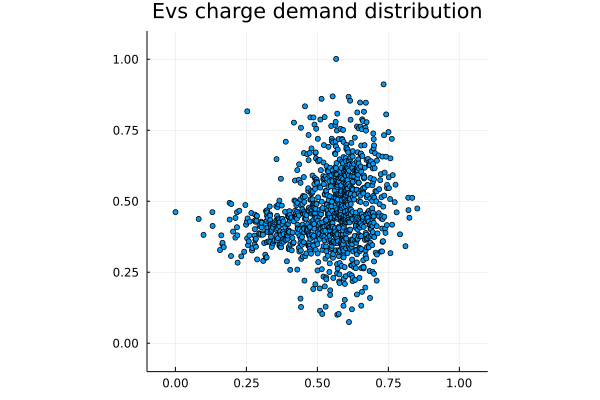

In [257]:
plot_locations(x, "Evs charge demand distribution")

### Plot stations locations

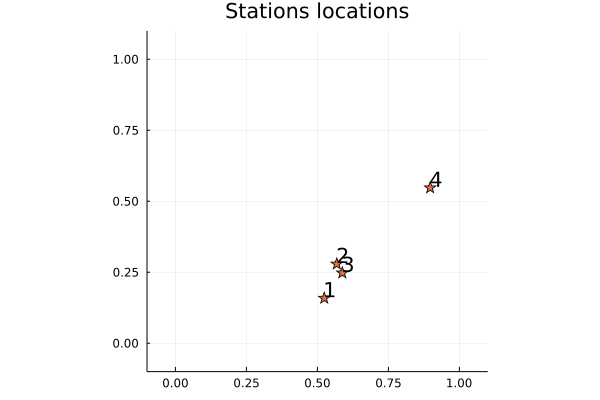

In [258]:
Random.seed!(25)

d = Distributions.Normal(0.5, 0.22)

y = sortslices(rand(d, (n,2)), dims = 1);

plot_stations(y, "Stations locations")

### Generar matriz de costo

In [259]:
C = get_cost_matrix(x, y, norm);
q = ones(m,1);

## III. Optmial transport for fixed locations
We assume that the station locations $\{ y_j \}$ have already been selected

### A. Free Capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

In [260]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [261]:
optimize!(model)

In [262]:
s = sum(value.(Pi), dims=1)'

4×1 adjoint(::Matrix{Float64}) with eltype Float64:
  33.0
 712.0
  45.0
 210.0

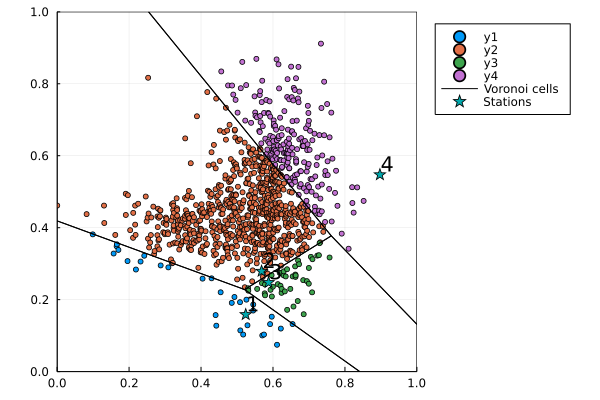

In [263]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

### B. Fixed Capacities

#### Simple discrete counterexample
$$C = \begin{bmatrix}
1 & 3\\
3 & 1
\end{bmatrix}$$

$$q = \begin{bmatrix}
1\\
2
\end{bmatrix}$$

$$s = \begin{bmatrix}
2 & 1
\end{bmatrix}$$

Then:

$$\Pi^{*} = \begin{bmatrix}
1 & 0\\
1 & 1
\end{bmatrix}$$

In [253]:
C1 = [1 3; 3 1]
q1 = [1; 2]
s = [2 1]


model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:2, 1:2] >=0 )
@constraint(model, sum(Pi, dims=2) .== q1)
@constraint(model, sum(Pi, dims=1) .== s )

@objective(model,Min, sum( C1.*Pi ))

#print(model)
model

optimize!(model)
value.(Pi)

2×2 Matrix{Float64}:
 1.0  0.0
 1.0  1.0

#### Proposition 1

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidad justa: $s_{j} \in Z, s_{j} > 0, \sum_{j} s_{j} = m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [225]:
#Vector de capacidades
aux = rand(n,1); #random proportion for s
s = round.(aux/sum(aux)*m); #normalization
s[argmax(s)] += (m - sum(s)); #error correction
s

30×1 Matrix{Float64}:
 10.0
 26.0
 34.0
 22.0
 36.0
 16.0
 15.0
  9.0
 16.0
 35.0
 45.0
 65.0
 69.0
  ⋮
 10.0
 71.0
 68.0
 28.0
 34.0
  8.0
 72.0
 50.0
 71.0
 37.0
 20.0
 27.0

In [226]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== 100*ones(n,1)' ) #FIXME: El s_max es el mismo en todas las estaciones (Ilustra mejor)

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [227]:
optimize!(model)
value.(Pi);

In [228]:
#[TODO] Find values not in 0 or 1 to verify
#find(value.(Pi) != 0 || value.(Pi) != 1);

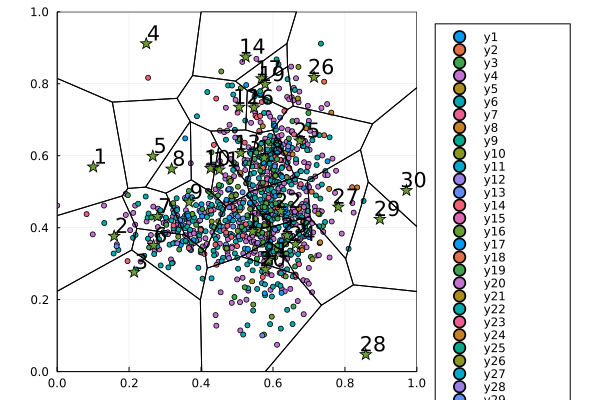

In [229]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

#### Case m = n

In [130]:
m2 = 10; # Demand locations count
n2 = 10; # Station locations count

x2 = sortslices(rand(m2,2), dims = 1);
y2 = sortslices(rand(n2,2), dims = 1);
C2 = get_cost_matrix(x2, y2, norm); #Matriz de costos
q2 = ones(m2,1);

#Vector de capacidades
s2 = ones(n2,1); 

In [131]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m2,1:n2]>=0)

@constraint(model, sum(Pi, dims=2) .== q2)
@constraint(model, sum(Pi, dims=1) .== s2' )

@objective(model,Min, sum( C2.*Pi ))

#print(model)
model;

In [132]:
optimize!(model)
value.(Pi);

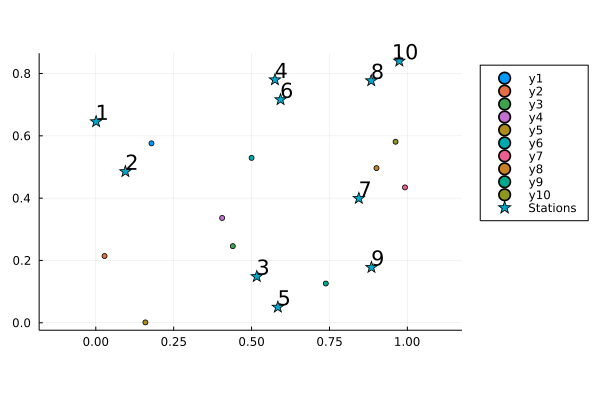

In [133]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x2, y2, Pi, false)

In [28]:
#Vector de capacidades
s = sum(value.(Pi), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### C. Constrained capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

#### Proposition 2

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidades topeadas (aseguran demanda): $\overline{s}_{j} \in Z, s_{j} > 0, \sum_{j} \overline{s}_{j} \ge m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\Pi_{ij} \in \{ 0, 1\}$)


In [230]:
#Vector de cotas de capacidad
aux = rand(n,1); #random proportion for s
tolerance = 0.2; 
s_max = round.(aux/sum(aux)*m*(1+tolerance)) #normalization

30×1 Matrix{Float64}:
 37.0
 20.0
 39.0
 34.0
 49.0
  6.0
 13.0
 38.0
 70.0
 47.0
 14.0
 68.0
 46.0
  ⋮
 68.0
 53.0
 60.0
 42.0
 13.0
 65.0
  4.0
 54.0
 45.0
 13.0
 67.0
 23.0

In [231]:
sum(s_max)

1202.0

In [232]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .<= 120*ones(n,1)') #s_max' )

@objective(model,Min, sum( C.*Pi ))

#print(model)
model;

In [233]:
optimize!(model)

In [234]:
value.(Pi);

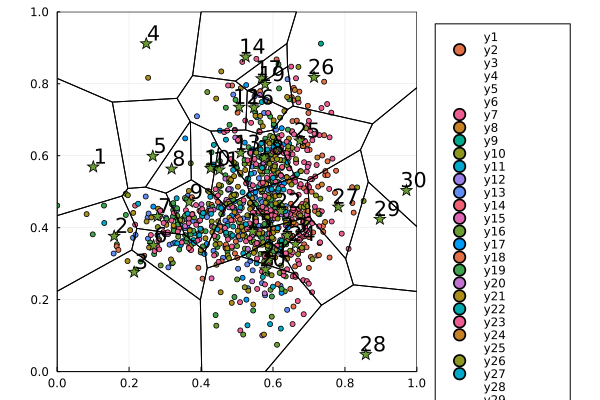

In [235]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

#### Penalized capacities

Suppose, instead, that one is designing an installation with known locations but still has not defined the relevant capacities. Leaving them complete free may be undesirable, but one could seek to even out the allocation somewhat between locations.

With this aim, we consider a problem where a soft penalty term to the transport cost:

$$ min \sum_{ij} c_{ij} \Pi_{ij} + \epsilon \sum_{j} \phi_{j}(s_{j})$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_{i}$$
$$\sum_{i} \Pi_{ij} = s_{j}$$

In this case, we use $\phi_{j}(s) = \frac{1}{2}s^{2}$

In [35]:
function phi(s)
    return 0.5*(s.^2)
end

phi (generic function with 1 method)

In [36]:
using Ipopt
epsilon = 0

model = JuMP.Model(Ipopt.Optimizer)

@variable(model, Pi[1:m,1:n]>=0)
@variable(model, s[1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .== s')

@objective(model,Min, sum( C.*Pi ) + epsilon*sum(phi(s)));


In [37]:
optimize!(model)
value.(Pi), objective_value(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    20010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    10010
                     variables with only lower bounds:    10010
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

([1.000000063998088 0.0 … 0.0 0.0; 1.0000000649581127 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 146.60684377031205)

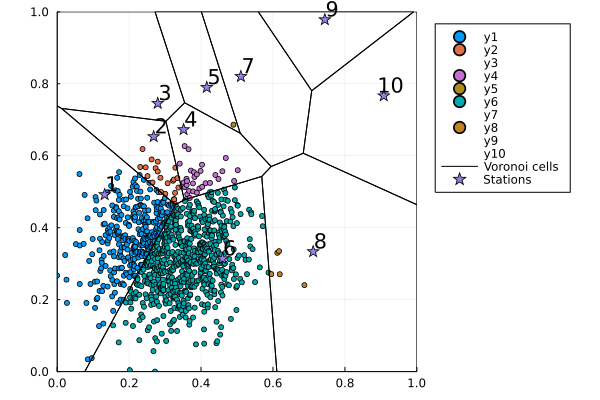

In [38]:
# Graficar la asignacion
Pi = value.(Pi) 
plot_assignments(x, y, Pi)

## IV. Location Selection
In this section we consider the situation where the location poitns are also part of the design.

### A. Free locations

[TODO] K - Means

### B. Sparse selection over a set of candidate locations

Example 1 - Verification

$$x = y = \begin{bmatrix}
1\\
2\\
5
\end{bmatrix}$$

Then:

$$C = \begin{bmatrix}
0 & 1 & 4\\
1 & 0 & 3\\
4 & 3 & 0
\end{bmatrix}$$

$$q = \begin{bmatrix}
2\\
3\\
1
\end{bmatrix}$$

$$\overline{s} = \begin{bmatrix}
s & s & s
\end{bmatrix}$$

Case 1: s = 5

In [39]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)

@constraint(model, sum(Pi, dims=2) .== q)
@constraint(model, sum(Pi, dims=1) .<= s_max' )

@objective(model,Min, sum( C.*Pi ));

In [40]:
optimize!(model)
value.(Pi), objective_value(model);

Case 2: s = 4

### MILP (Mixed-integer linear programming)

$$min \sum_{ij} c_{ij} \Pi_{ij}$$

Subject to:

$$\sum_{j} \Pi_{ij} = q_i$$
$$\sum_{i} \Pi_{ij} \le b_{j}\overline{s}_{j}$$
$$\sum_{j} b_{j} \le k$$
$$b_{j} \in \{ 0, 1\}$$

Where: 

$b_{j}$ indicates whether station $y_{j}$ is active or not

$k$ is the count of active actions

In [236]:
k = 4
q = 1*ones(m,1)
s_max = 500*1.2*ones(n,1);
# Validar que la cantidad de prendidos, con la capacidad q, den para cubrir todos los EVs

In [237]:
model = JuMP.Model(Mosek.Optimizer)
#model = JuMP.Model(GLPK.Optimizer)

@variable(model,Pi[1:m,1:n]>=0)
@variable(model, b[1:n], Bin)

@constraint(model, sum(Pi, dims=2).== q)
@constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
@constraint(model, sum(b) <= k)

@objective(model,Min, sum( C.*Pi ));

In [238]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30030           
  Matrix variables       : 0               
  Integer variables      : 30              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.16
Presolved problem: 30030 variables, 1031 constraints, 60060 non-zeros
Presolved problem: 0 general integer, 30 binary, 30000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   6.9314433666e+01     NA          0.3   
0        1        1        0        2.8615877207e+02     6.9314433666e+01     75.78       0.5   
0        1        1        0        9.3939416993e+01    

91.33390824169643

In [239]:
function plot_assignments_2(x, y, Pi, b)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    k = Int(round(sum(b)));
    
    #Points of availabile stations
    points = [Point2(y[i,1], y[i,2]) for i in 1:n]
    
    not_available_stations_index = findall(x -> x <= 0.5, b)
   
    deleteat!(points, not_available_stations_index)


    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    
    #Plot cars locations
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    
    #Plot voronoi lines
    plot!(tess, color = :black)
    
 
    #Plot available stations locations
    available_stations_positions = y;
    
    available_stations_positions = delete_row(available_stations_positions, not_available_stations_index)
      
    scatter!(available_stations_positions[:,1], available_stations_positions[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    
    
    #Plot available stations number text
    available_stations_index = findall(x -> x > 0.5, b)
    
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(available_stations_index[i], :black)) for i in 1:k]) # Add Station Number
end

plot_assignments_2 (generic function with 1 method)

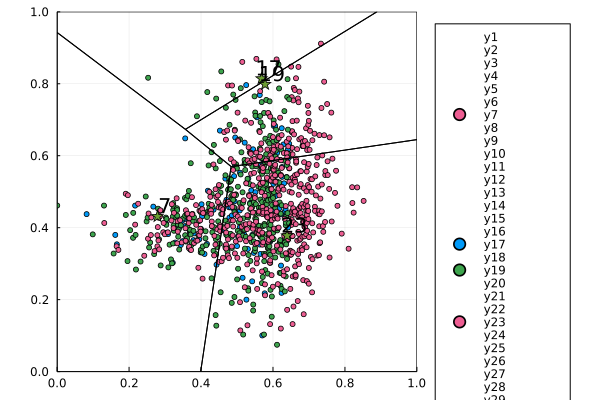

In [240]:
# Graficar la asignacion
Pi = value.(Pi) 
b = value.(b)
plot_assignments_2(x, y, Pi, b)

In [215]:
s = sum(round.(value.(Pi)), dims=1)'

30×1 adjoint(::Matrix{Float64}) with eltype Float64:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
 202.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 336.0
   0.0
   0.0
   0.0
 336.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In [11]:
function Solve_MILP(k, C)

    m = size(C)[1];
    n = size(C)[2];

    q = 1.0 * ones(m,1);
    
    #tolerance = 20;
    
    #s_max = (m / k) * (1 + tolerance / 100) * ones(n,1);
    s_max = 250 * ones(n,1);

    model = JuMP.Model(Mosek.Optimizer);

    @variable(model,Pi[1:m,1:n] >= 0)
    @variable(model, b[1:n], Bin)

    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return objective_value(model);
    
end

Solve_MILP (generic function with 1 method)

In [14]:
function Create_random_b(k, n)
    
    b = zeros(n);

    random_availabile_stations = sample(1:n, k, replace=false)

    for i in 1:k
       b[random_availabile_stations[i]] = 1;
    end
    
    return b;
end


function Solve_MILP_random_b(k, C)

    m = size(C)[1];
    n = size(C)[2];
    
    q = 1.0 * ones(m,1);
    
    s_max = 250 * ones(n,1);
    
    #max_available_stations = 10;
    
    b = Create_random_b(k, n);

    model = JuMP.Model(Mosek.Optimizer);

    @variable(model,Pi[1:m,1:n] >= 0)
    
    @constraint(model, sum(Pi, dims=2).== q)
    @constraint(model, sum(Pi, dims=1)' .<= (b.*s_max) )
    @constraint(model, sum(b) <= k)

    @objective(model, Min, sum( C.*Pi ));

    optimize!(model);

    return objective_value(model);
    
end

Solve_MILP_random_b (generic function with 1 method)

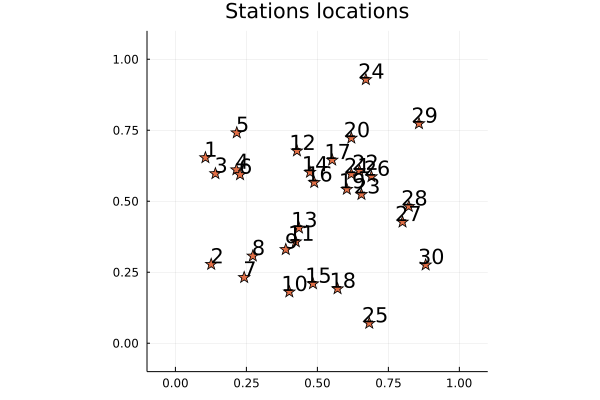

In [169]:
m = 1000; # Demand locations count
n = 30; # Station locations count
norm = 2; # Manhattan Metric

Random.seed!(9)

d = Distributions.Normal(0.5,0.22)

y = sortslices(rand(d, (n,2)), dims = 1);

C = get_cost_matrix(x, y, norm);
q = ones(m,1);

plot_stations(y, "Stations locations")

In [170]:
max_k = 10;

cost_per_k = zeros(max_k - 3);

for k in 4:max_k
    cost = Solve_MILP(k, C);
    println("Cost [$k]: $cost");
    cost_per_k[k - 3] = cost;
end

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30030           
  Matrix variables       : 0               
  Integer variables      : 30              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.16
Presolved problem: 30030 variables, 1031 constraints, 60060 non-zeros
Presolved problem: 0 general integer, 30 binary, 30000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   6.9314433666e+01     NA          0.3   
0        1        1        0        1.9081378906e+02     6.9314433666e+01     63.67       0.5   
0        1        1        0        1.7862005689e+02    

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30030           
  Matrix variables       : 0               
  Integer variables      : 30              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.16
Presolved problem: 30030 variables, 1031 constraints, 60060 non-zeros
Presolved problem: 0 general integer, 30 binary, 30000 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   6.9314433666e+01     NA          0.3   
0        1        1        0        1.9081378906e+02     6.9314433666e+01     63.67       0.6   
0        1        1        0        8.7187134497e+01    

106      126      22       5        7.9439927585e+01     7.7711831279e+01     2.18        8.3   
126      146      22       9        7.9439927585e+01     7.7711831279e+01     2.18        8.6   
146      166      32       4        7.9439927585e+01     7.7744919225e+01     2.13        9.0   
178      198      30       9        7.9439927585e+01     7.7744919225e+01     2.13        9.6   
206      223      24       13       7.9064543839e+01     7.7744919225e+01     1.67        10.0  
230      244      20       5        7.9064543839e+01     7.8718542807e+01     0.44        10.4  
250      260      10       8        7.9064543839e+01     7.8738227967e+01     0.41        10.7  
An optimal solution satisfying the relative gap tolerance of 1.00e-02(%) has been located.
The relative gap is 0.00e+00(%).
An optimal solution satisfying the absolute gap tolerance of 0.00e+00 has been located.
The absolute gap is 0.00e+00.

Objective of best integer solution : 7.906454383861e+01      
Best objective b

5        25       1        0        7.4232106850e+01     7.3384440678e+01     1.14        3.3   
25       45       1        0        7.4232106850e+01     7.3384440678e+01     1.14        3.7   
45       65       1        0        7.4232106850e+01     7.3384440678e+01     1.14        3.9   
65       85       1        0        7.4232106850e+01     7.3384440678e+01     1.14        4.2   
78       98       14       5        7.4232106850e+01     7.3506921422e+01     0.98        4.6   
104      124      16       8        7.4232106850e+01     7.3643132275e+01     0.79        5.0   
120      140      18       10       7.4232106850e+01     7.3643132275e+01     0.79        5.2   
136      155      14       12       7.4232106850e+01     7.3643132275e+01     0.79        5.3   
148      166      4        13       7.4232106850e+01     7.3643132275e+01     0.79        5.5   
159      177      3        4        7.4232106850e+01     7.3720583515e+01     0.69        5.7   
170      188      2        10 

### Cost per station available

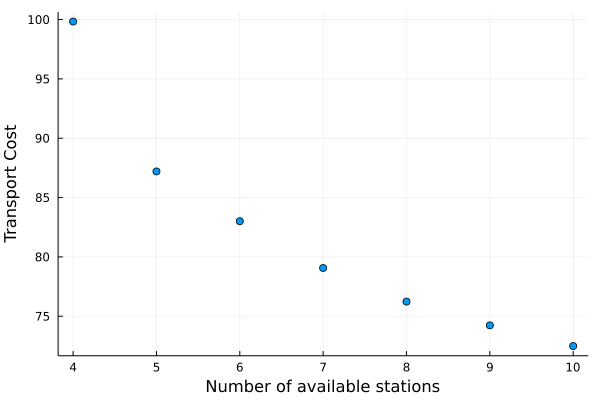

In [171]:
ks = [4:max_k];

scatter(ks, cost_per_k, xaxis = "Number of available stations", yaxis = "Transport Cost", legend = false)

### Marginal cost for adding a station

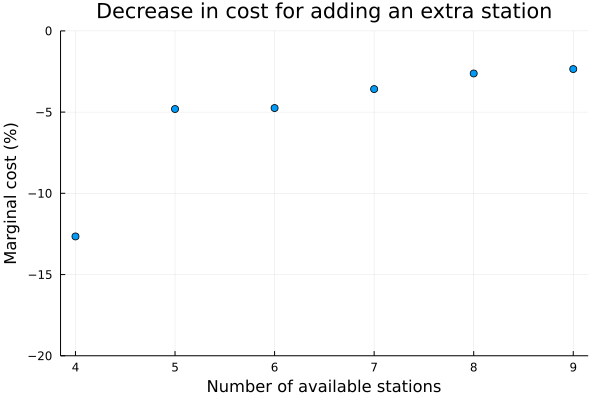

In [175]:
marginal_cost = diff(cost_per_k);

marginal_cost_percentage = 100 * (marginal_cost ./ cost_per_k[1: max_k - 4]);

ks = [4:max_k-1];

scatter(ks, marginal_cost_percentage, xaxis = "Number of available stations", yaxis = "Marginal cost (%)", title = "Decrease in cost for adding an extra station", legend = false, ylim = (-20, 0))

In [173]:
cost_per_k_random_allocation = zeros(max_k - 3);

for k in 4:max_k
    cost = Solve_MILP_random_b(k, C);
    println("Cost [$k]: $cost");
    cost_per_k_random_allocation[k - 3] = cost;
end

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30000           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30000           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

Cost [8]: 114.76953347589158
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1031            
  Cones                  : 0               
  Scalar variables       : 30000           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                

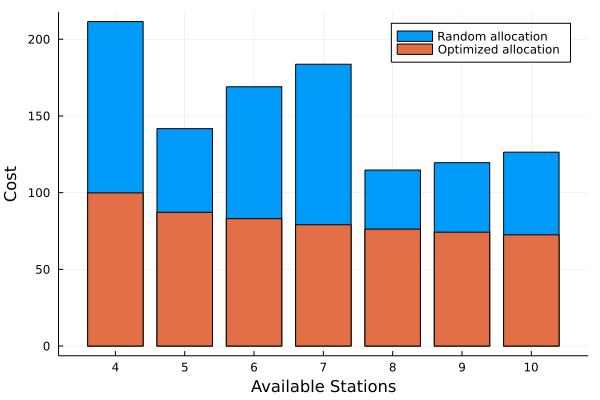

In [174]:
ks = [4:max_k];

bar(ks, cost_per_k_random_allocation, labels = "Random allocation")
bar!(ks, cost_per_k, labels = "Optimized allocation")

xlabel!("Available Stations")
ylabel!("Cost")